In [24]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import sklearn.svm
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgbm

#### data preparation

In [25]:
dfX = pd.read_csv('data_hursts.csv',index_col=0)
dfY = pd.read_csv('data_labels.csv',index_col=0)

dfY = dfY[dfY['CDR']!=2]
Y = dfY['CDR'].dropna()
y = Y.to_numpy()
y = (y*2).astype(int)
X = dfX.loc[Y.index].to_numpy()

In [26]:
verbose = False
random_seed = 1234
cv_param_folds = 5
cv_select_folds = 5

n_jobs = -1

###### Basic model - SVC

In [5]:
pipeline = []

pipeline.append(('scaler',StandardScaler()))
pipeline.append(('resampler',SMOTE(random_state = random_seed)))
pipeline.append(('svc',sklearn.svm.SVC(verbose=verbose)))

model_pipeline = Pipeline(pipeline)

param_grid = [{'C': 10.**np.arange(-3,3,2),
               'gamma': 10.**np.arange(-3,1,1)}]

def pipeline_param_grid(param_grid,model_name):
    pg = []
    for x in param_grid:
        d = {}
        for k,v in x.items():
            d[model_name+'__'+k] = v
        pg += [d]

    return pg

param_grid = pipeline_param_grid(param_grid,'svc')

mcc = sklearn.metrics.make_scorer(sklearn.metrics.matthews_corrcoef)

inner_cv = StratifiedKFold(n_splits=cv_param_folds,
                           shuffle=True,
                           random_state=random_seed)

clf = GridSearchCV(estimator = model_pipeline,
                param_grid = param_grid,
                cv = inner_cv,
                verbose = verbose,
                scoring = dict(accuracy='accuracy',
                                f1_macro='f1_macro',
                                mcc=mcc),
                refit = 'mcc')

##### Best model - gb tree

In [23]:
pipeline = []

pipeline.append(('scaler',StandardScaler()))
pipeline.append(('resampler',SMOTE(random_state = random_seed)))
pipeline.append(('lgbm',lgbm.LGBMClassifier(verbose=int(verbose),n_jobs=n_jobs)))

model_pipeline = Pipeline(pipeline)

param_grid = [{'num_leaves': [15,30,45],
               # 'max_depth': [-1],
               'n_estimators': [20,40,60,80,100]}]

def pipeline_param_grid(param_grid,model_name):
    pg = []
    for x in param_grid:
        d = {}
        for k,v in x.items():
            d[model_name+'__'+k] = v
        pg += [d]

    return pg

param_grid = pipeline_param_grid(param_grid,'lgbm')

mcc = sklearn.metrics.make_scorer(sklearn.metrics.matthews_corrcoef)

inner_cv = StratifiedKFold(n_splits=cv_param_folds,
                           shuffle=True,
                           random_state=random_seed)

clf = GridSearchCV(estimator = model_pipeline,
                param_grid = param_grid,
                cv = inner_cv,
                verbose = verbose,
                scoring = dict(accuracy='accuracy',
                                f1_macro='f1_macro',
                                mcc=mcc),
                refit = 'mcc')

# clf = RandomizedSearchCV(estimator = model_pipeline,
#                 param_grid = param_grid,
#                 cv = inner_cv,
#                 verbose = verbose,
#                 scoring = dict(accuracy='accuracy',
#                                 f1_macro='f1_macro',
#                                 mcc=mcc),
#                 refit = 'mcc')

TypeError: RandomizedSearchCV.__init__() got an unexpected keyword argument 'param_grid'

#### training loop

In [22]:
outer_cv = StratifiedKFold(n_splits=cv_select_folds,
                           shuffle=True,
                           random_state=random_seed)

cv_select_results = cross_validate(estimator = clf,
                                       X = X,
                                       y = y,
                                       cv = outer_cv,
                                       n_jobs = n_jobs,
                                       verbose = verbose,
                                       return_estimator = True,
                                       return_train_score = True,
                                       scoring = dict(accuracy='accuracy',
                                                      f1_macro='f1_macro',
                                                      mcc=mcc))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fa9c62618a0>
Traceback (most recent call last):
  File "/home/grela/local_project/2022.07.12-peano-resurrection/2023.10.13-refactor/.venv/lib/python3.11/site-packages/lightgbm/basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 

KeyboardInterrupt



In [18]:
cv_select_results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1_macro', 'train_f1_macro', 'test_mcc', 'train_mcc'])

In [19]:
test_acc = cv_select_results['test_accuracy'].mean()
test_mcc = cv_select_results['test_mcc'].mean()
test_f1 = cv_select_results['test_f1_macro'].mean()

In [20]:
print(f'test_acc = {test_acc:.3f}; test_mcc = {test_mcc:.3f}; test_f1 = {test_f1:.3f}')

test_acc = 0.502; test_mcc = 0.089; test_f1 = 0.372


In [15]:
out = permutation_test_score(estimator = clf, X = X,y = y, cv = outer_cv, scoring = 'accuracy')
print(out)


KeyboardInterrupt



(array([ 1.,  0.,  0.,  0.,  0.,  3.,  3.,  2.,  3.,  3.,  2.,  3., 10.,
         9., 10.,  9., 12., 16.,  8.,  6.]),
 array([0.25226642, 0.26841351, 0.28456059, 0.30070768, 0.31685476,
        0.33300185, 0.34914894, 0.36529602, 0.38144311, 0.39759019,
        0.41373728, 0.42988437, 0.44603145, 0.46217854, 0.47832562,
        0.49447271, 0.5106198 , 0.52676688, 0.54291397, 0.55906105,
        0.57520814]),
 <BarContainer object of 20 artists>)

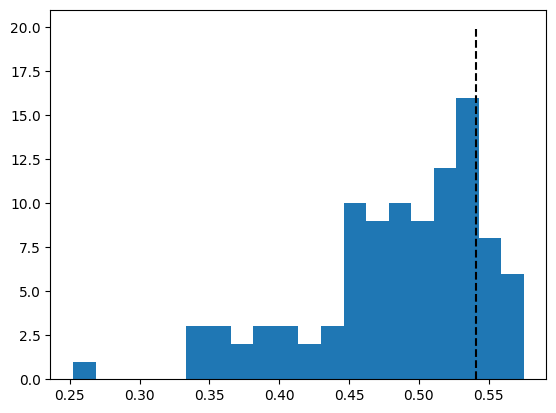

In [82]:
plt.vlines(x = out[0],ymin=0,ymax=20,colors='k',ls='--')
plt.hist(out[1],20)


In [63]:
permutation_test_score?


Signature:
permutation_test_score(
    estimator,
    X,
    y,
    *,
    groups=None,
    cv=None,
    n_permutations=100,
    n_jobs=None,
    random_state=0,
    verbose=0,
    scoring=None,
    fit_params=None,
)
Docstring:
Evaluate the significance of a cross-validated score with permutations.

Permutes targets to generate 'randomized data' and compute the empirical
p-value against the null hypothesis that features and targets are
independent.

The p-value represents the fraction of randomized data sets where the
estimator performed as well or better than in the original data. A small
p-value suggests that there is a real dependency between features and
targets which has been used by the estimator to give good predictions.
A large p-value may be due to lack of real dependency between features
and targets or the estimator was not able to use the dependency to
give good predictions.

Read more in the :ref:`User Guide <permutation_test_score>`.

Parameters
----------
estimator : est

In [51]:
y_pred = cross_val_predict(estimator = clf, X = X, y = y, cv = outer_cv, n_jobs = n_jobs, verbose = verbose)

In [32]:
print(classification_report(y_true = y, y_pred = y_pred, target_names = ['0','0.5','1.0']))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       135
         0.5       0.38      0.31      0.34        70
         1.0       0.19      0.11      0.14        28

    accuracy                           0.54       233
   macro avg       0.40      0.39      0.39       233
weighted avg       0.50      0.54      0.52       233



In [38]:
confusion_matrix(y,y_pred)

array([[101,  28,   6],
       [ 41,  22,   7],
       [ 17,   8,   3]])

In [9]:
cv_select_results['test_accuracy'].mean(),cv_select_results['test_accuracy'].std()

(0.5407955596669749, 0.034052606808905754)